In [24]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random

In [25]:
df = pd.read_csv('..\dataset\Employment_Unemployment_GDP_data.csv')

output_path = r"..\output\figure"
os.makedirs(output_path, exist_ok=True)

print(df.head().to_string())

df.rename(columns={
    'Country Name': 'Country',
    'Employment Sector: Agriculture': 'Labor_Agriculture',
    'Employment Sector: Industry': 'Labor_Industry',
    'Employment Sector: Services': 'Labor_Services',
    'Unemployment Rate': 'Unemployment_Rate',
    'GDP (in USD)': 'GDP'
}, inplace=True)

df.sample(5)



  Country Name  Year  Employment Sector: Agriculture  Employment Sector: Industry  Employment Sector: Services  Unemployment Rate  GDP (in USD)
0      Albania  1991                       53.299533                    12.172764                    34.527781             10.304  1.099559e+09
1      Algeria  1991                       24.118566                    25.067734                    50.813700             20.600  4.571568e+10
2       Angola  1991                       40.071857                     8.163345                    51.764822             16.855  1.060378e+10
3    Argentina  1991                       13.669999                    28.505903                    57.824098              5.440  1.897200e+11
4      Armenia  1991                       54.263252                    15.790454                    29.946294              1.783  2.069870e+09


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ACER\AppData\Local\Temp\ipykernel_3444\4076905125.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('..\dataset\Employment_Unemployment_GDP_data.csv')


,Country,Year,Labor_Agriculture,Labor_Industry,Labor_Services,Unemployment_Rate,GDP
2068,North Macedonia,2002,23.923529,33.298209,42.778262,31.940,4.018366e+09
5318,Mali,2020,68.061812,9.306093,22.632081,3.528,2.069856e+10
362,Bolivia,1993,42.903959,18.896138,38.199903,3.050,5.734699e+09
4080,Peru,2013,26.018429,17.796979,56.184592,3.575,2.011755e+11
5178,Sierra Leone,2019,44.845533,10.966026,44.188441,3.203,6.526184e+09


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5751 entries, 0 to 5750
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            5751 non-null   object 
 1   Year               5751 non-null   int64  
 2   Labor_Agriculture  5751 non-null   float64
 3   Labor_Industry     5751 non-null   float64
 4   Labor_Services     5751 non-null   float64
 5   Unemployment_Rate  5751 non-null   float64
 6   GDP                5751 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 314.6+ KB


In [27]:
print(df.isna().sum()/len(df) * 100)

Country              0.0
Year                 0.0
Labor_Agriculture    0.0
Labor_Industry       0.0
Labor_Services       0.0
Unemployment_Rate    0.0
GDP                  0.0
dtype: float64


In [28]:
df.dropna(inplace=True)
df.tail()

,Country,Year,Labor_Agriculture,Labor_Industry,Labor_Services,Unemployment_Rate,GDP
5746,Viet Nam,2022,33.609304,30.611964,35.778734,1.523,4.134452e+11
5747,Virgin Islands (U.S.),2022,1.293486,15.193240,83.513274,13.007,4.672000e+09
5748,West Bank and Gaza,2022,6.220994,32.609239,61.169768,24.420,1.916550e+10
5749,Zambia,2022,57.314602,10.346079,32.339318,5.995,2.916378e+10
5750,Zimbabwe,2022,52.610143,13.750807,33.639050,10.087,3.278966e+10


In [29]:
print(df.isna().sum())

Country              0
Year                 0
Labor_Agriculture    0
Labor_Industry       0
Labor_Services       0
Unemployment_Rate    0
GDP                  0
dtype: int64


In [30]:
# 3.2.1. Xử lý giá trị thiếu
df.fillna(df.mean(numeric_only=True), inplace=True)
print("\n Đã xử lý giá trị thiếu.")


 Đã xử lý giá trị thiếu.



Trước khi xử lý outlier: (5751, 7)
Sau khi xử lý outlier: (5751, 7)


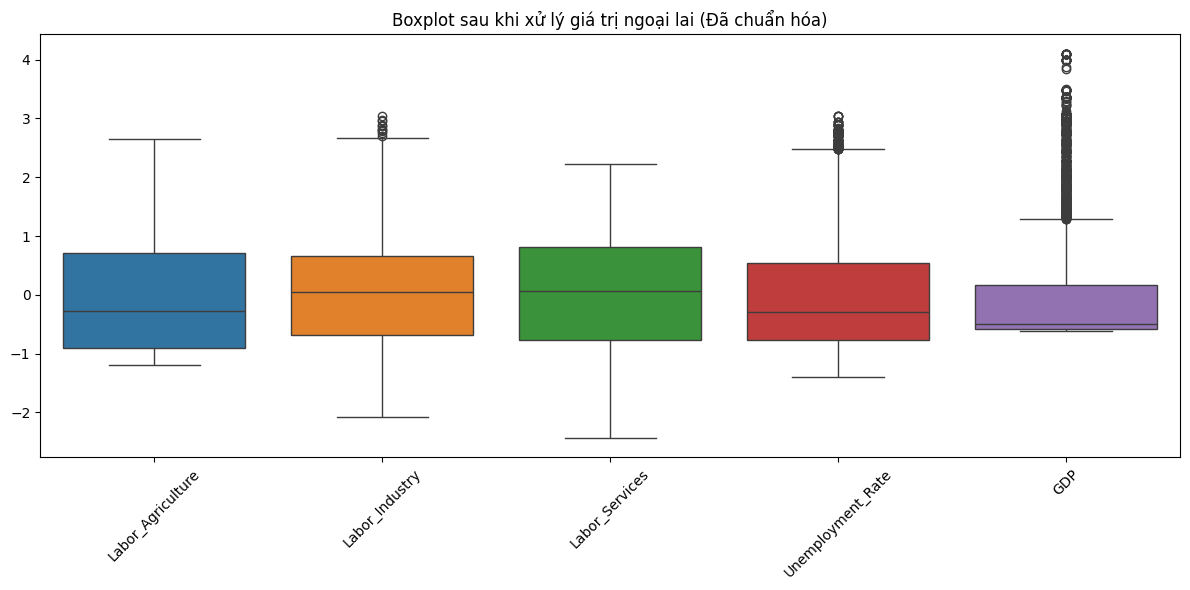

In [31]:
# 3.2.2. Xử lý outlier (theo từng năm và quốc gia)
print("\nTrước khi xử lý outlier:", df.shape)
def handle_outliers_by_year(data):
    numeric_cols = ['Labor_Agriculture', 'Labor_Industry', 'Labor_Services', 'Unemployment_Rate', 'GDP']
    df_clean = data.copy()
    for year in df_clean['Year'].unique():
        year_data = df_clean[df_clean['Year'] == year]
        Q1 = year_data[numeric_cols].quantile(0.25)
        Q3 = year_data[numeric_cols].quantile(0.75)
        IQR = Q3 - Q1
        for col in numeric_cols:
            lower_bound = Q1[col] - 1.5 * IQR[col]
            upper_bound = Q3[col] + 1.5 * IQR[col]
            mask = df_clean['Year'] == year
            df_clean.loc[mask, col] = df_clean.loc[mask, col].clip(lower_bound, upper_bound)
    
    return df_clean
df = handle_outliers_by_year(df)
print("Sau khi xử lý outlier:", df.shape)
plt.figure(figsize=(12,6))
numeric_cols = ['Labor_Agriculture', 'Labor_Industry', 'Labor_Services', 'Unemployment_Rate', 'GDP']
df_normalized = df[numeric_cols].apply(lambda x: (x - x.mean()) / x.std())
sns.boxplot(data=df_normalized)
plt.title("Boxplot sau khi xử lý giá trị ngoại lai (Đã chuẩn hóa)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_path, "boxplot_after_outliers.png"))
plt.show()
plt.close()

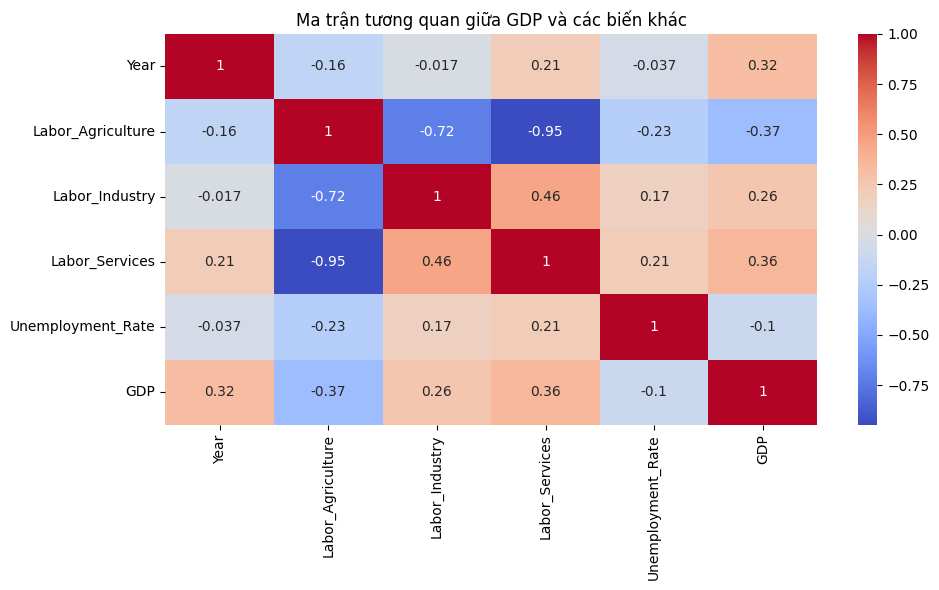

In [32]:
# 3.2.3. Ma trận tương quan
plt.figure(figsize=(10, 6))
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Ma trận tương quan giữa GDP và các biến khác")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "heatmap_correlation.png"))
plt.show()
plt.close()


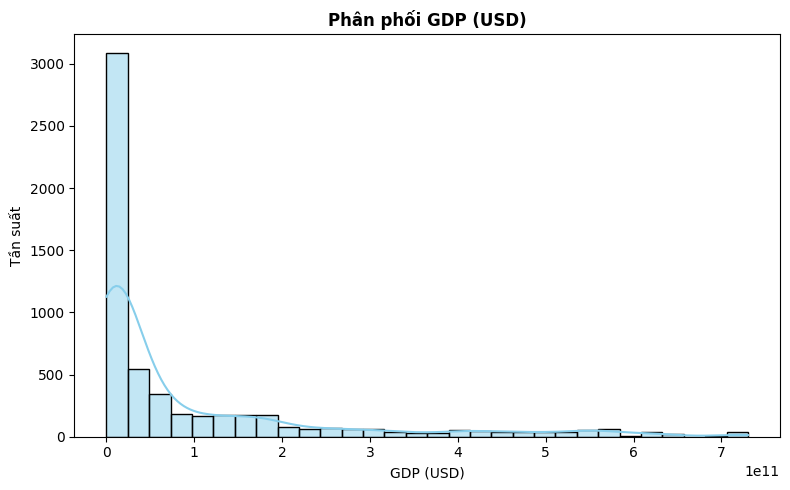

✅ Đã lưu biểu đồ: gdp_distribution.png


In [33]:
plt.figure(figsize=(8,5))
sns.histplot(df['GDP'], kde=True, color='skyblue', bins=30)
plt.title("Phân phối GDP (USD)", fontweight='bold')
plt.xlabel("GDP (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()

output_path = r"..\output\figure"
os.makedirs(output_path, exist_ok=True)
plt.savefig(os.path.join(output_path, "gdp_distribution.png"))
plt.show()
plt.close()
print("✅ Đã lưu biểu đồ: gdp_distribution.png")

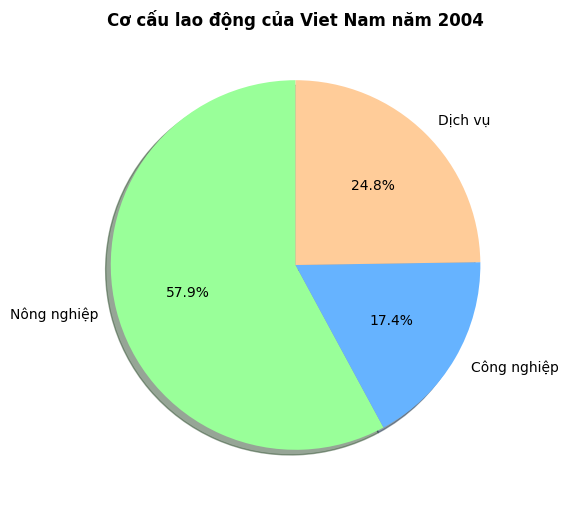

In [34]:
country_name = "Viet Nam"
year_selected = 2004
data_country = df[(df["Country"] == country_name) & (df["Year"] == year_selected)]

if not data_country.empty:
    values = [
        data_country["Labor_Agriculture"].values[0],
        data_country["Labor_Industry"].values[0],
        data_country["Labor_Services"].values[0]
    ]
    labels = ["Nông nghiệp", "Công nghiệp", "Dịch vụ"]
    colors = ['#99ff99', '#66b3ff', '#ffcc99']

    plt.figure(figsize=(6,6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True, colors=colors)
    plt.title(f"Cơ cấu lao động của {country_name} năm {year_selected}", fontweight='bold')
    output_path = r"..\output\figure"
    os.makedirs(output_path, exist_ok=True)
    save_path = os.path.join(output_path, f"pie_labor_{country_name.replace(' ', '_')}_{year_selected}.png")
    plt.savefig(save_path)
    plt.show()
    plt.close()
else:
    all_years = df[df["Country"] == country_name]["Year"].sort_values(ascending=False)
    if not all_years.empty:
        print(f"⚠️ Không có dữ liệu cho {country_name} năm {year_selected}.")
        latest_year = all_years.iloc[0]
        print(f"💡 Năm gần nhất có dữ liệu là: {latest_year}")
    else:
        print(f"⚠️ Không tìm thấy dữ liệu cho {country_name}.")

C:\Users\ACER\AppData\Local\Temp\ipykernel_3444\704722635.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unemp_random.index, y=unemp_random.values, palette="coolwarm")


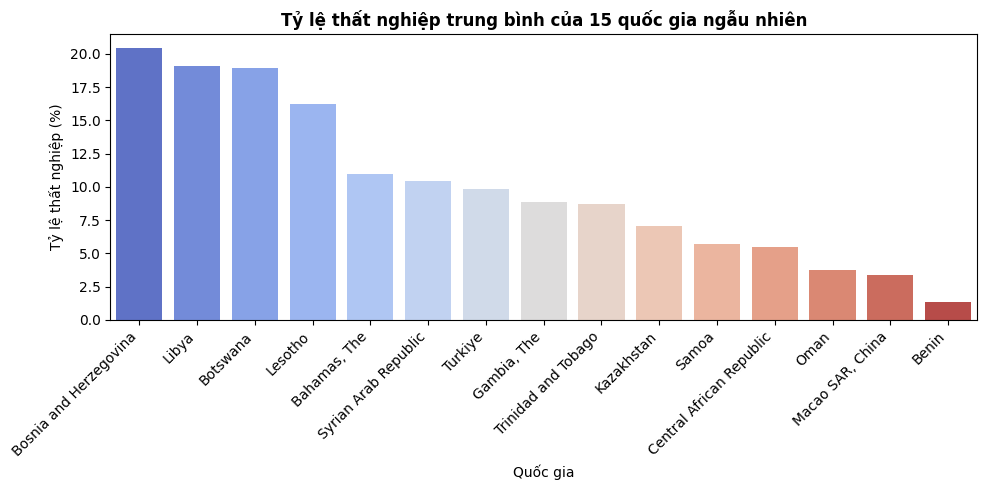

✅ Đã lưu biểu đồ tại: ..\output\figure\unemployment_random_15_countries.png


In [35]:
countries = df["Country"].unique()
random_countries = random.sample(list(countries), 15)
unemp_random = df[df["Country"].isin(random_countries)] \
    .groupby("Country")["Unemployment_Rate"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=unemp_random.index, y=unemp_random.values, palette="coolwarm")
plt.title("Tỷ lệ thất nghiệp trung bình của 15 quốc gia ngẫu nhiên", fontweight='bold')
plt.ylabel("Tỷ lệ thất nghiệp (%)")
plt.xlabel("Quốc gia")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_path = os.path.join(output_path, "unemployment_random_15_countries.png")
plt.savefig(save_path)
plt.show()
plt.close()

print(f"✅ Đã lưu biểu đồ tại: {save_path}")

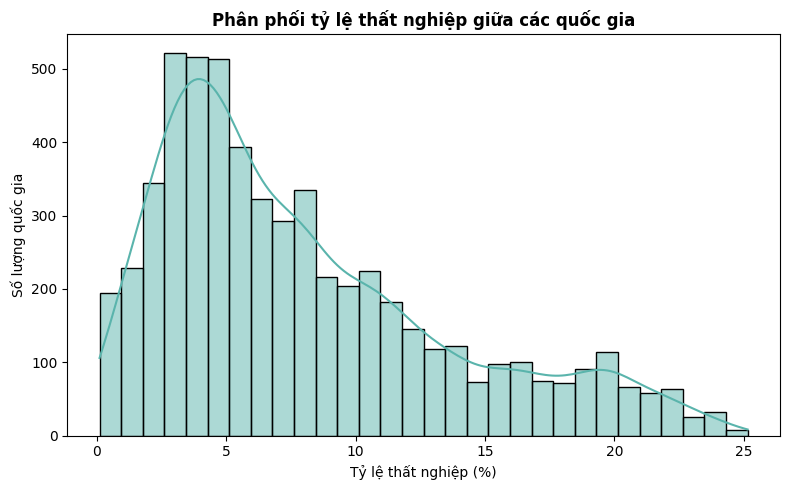

In [53]:
plt.figure(figsize=(8,5))
sns.histplot(df["Unemployment_Rate"], bins=30, kde=True, color="#5ab4ac")
plt.title("Phân phối tỷ lệ thất nghiệp giữa các quốc gia", fontweight="bold")
plt.xlabel("Tỷ lệ thất nghiệp (%)")
plt.ylabel("Số lượng quốc gia")
plt.tight_layout()

save_path = os.path.join(output_path, "unemployment_distribution.png")
plt.savefig(save_path)
plt.show()
plt.close()


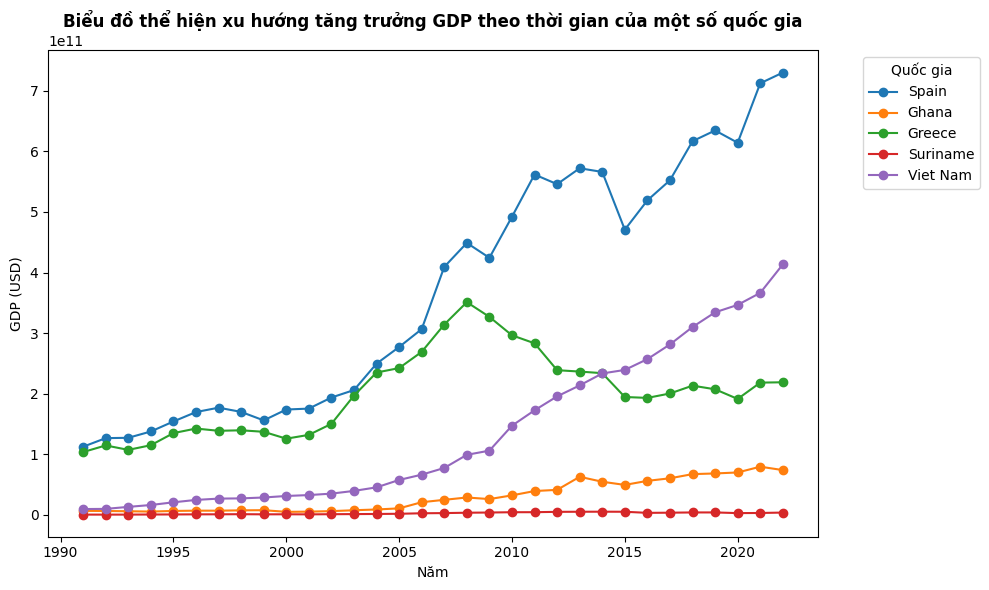

In [71]:

countries = random.sample(list(df["Country"].unique()), 5)

plt.figure(figsize=(10,6))
for country in countries:
    data_country = df[df["Country"] == country].sort_values(by="Year")
    plt.plot(data_country["Year"], data_country["GDP"], marker='o', label=country)

plt.title("Biểu đồ thể hiện xu hướng tăng trưởng GDP theo thời gian của một số quốc gia", fontweight='bold')
plt.xlabel("Năm")
plt.ylabel("GDP (USD)")
plt.legend(title="Quốc gia", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

save_path = os.path.join(output_path, "gdp_trend_random_countries.png")
plt.savefig(save_path)
plt.show()
plt.close()



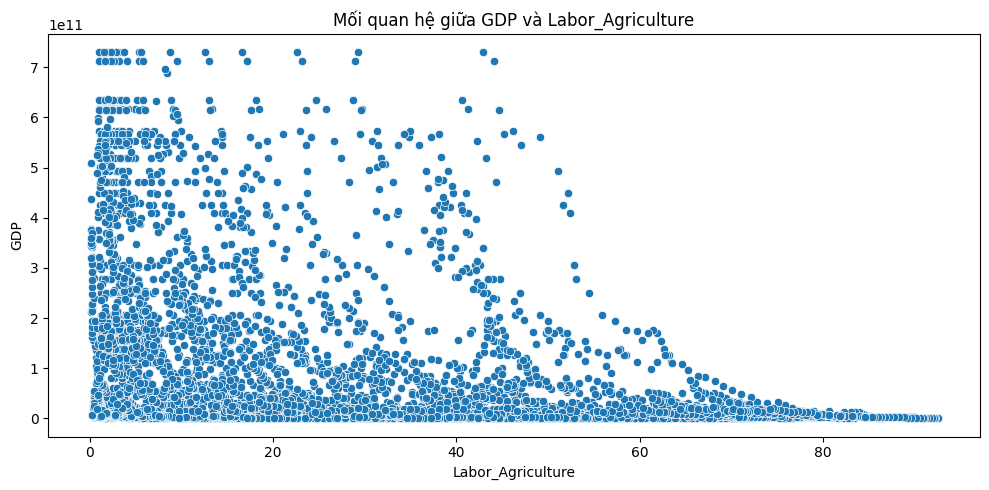

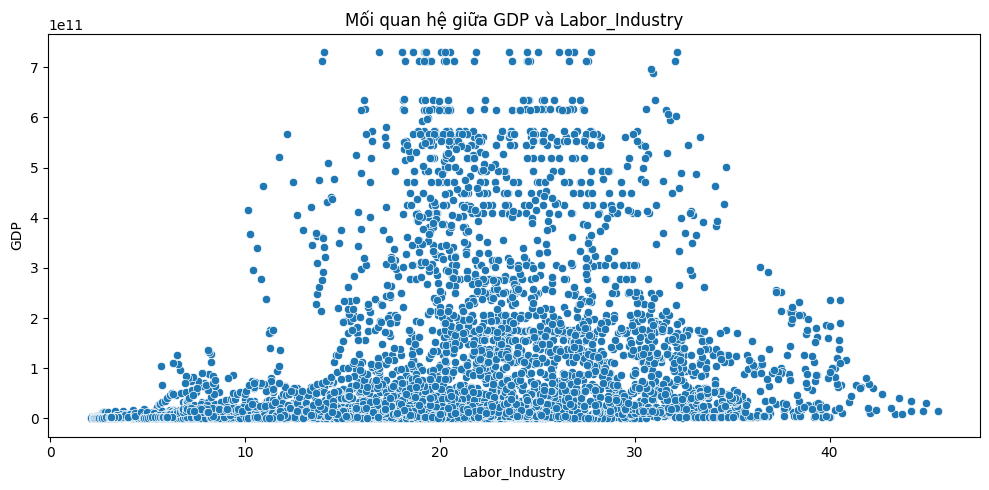

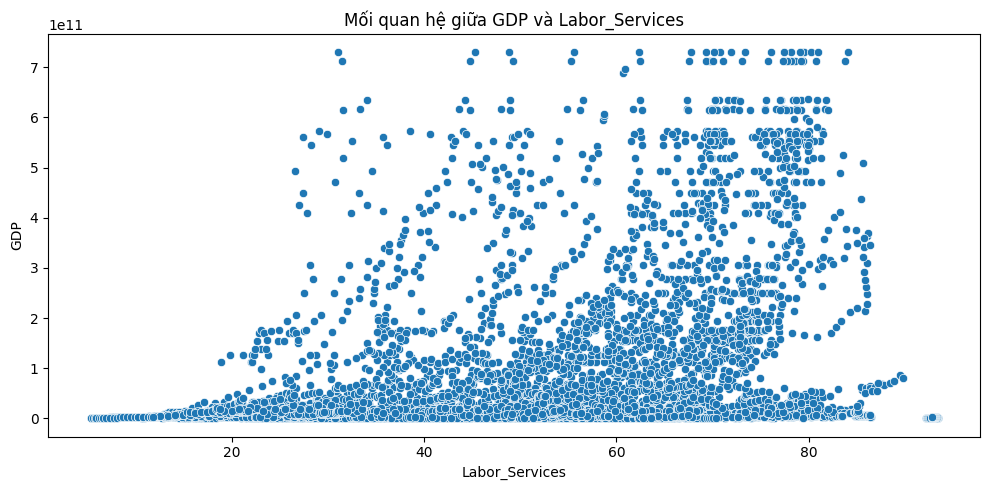

In [57]:
for col in ['Labor_Agriculture', 'Labor_Industry', 'Labor_Services']:
    plt.figure(figsize=(10,5))
    sns.scatterplot(x=df[col], y=df['GDP'])
    plt.title(f"Mối quan hệ giữa GDP và {col}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f"scatter_{col}.png"))
    plt.show()
    plt.close()


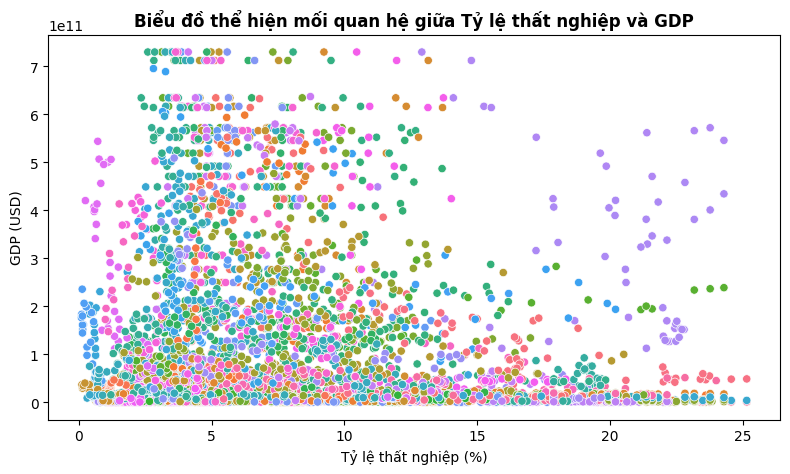

✅ Đã lưu biểu đồ tại: ..\output\figure\unemployment_vs_gdp.png


In [83]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df["Unemployment_Rate"], y=df["GDP"], hue=df["Country"], legend=False)
plt.title("Biểu đồ thể hiện mối quan hệ giữa Tỷ lệ thất nghiệp và GDP", fontweight='bold')
plt.xlabel("Tỷ lệ thất nghiệp (%)")
plt.ylabel("GDP (USD)")
plt.tight_layout()

save_path = os.path.join(output_path, "unemployment_vs_gdp.png")
plt.savefig(save_path)
plt.show()
plt.close()

print(f"✅ Đã lưu biểu đồ tại: {save_path}")


In [38]:
le = LabelEncoder()
df["Country_Code"] = le.fit_transform(df["Country"])
os.makedirs(r"..\output\model", exist_ok=True)
joblib.dump(le, r"..\output\model\country_encoder.joblib")

print(" Đã lưu encoder tại ..\\output\\model\\country_encoder.joblib")

 Đã lưu encoder tại ..\output\model\country_encoder.joblib


In [84]:

X = df[['Country_Code', 'Year', 'Labor_Agriculture', 'Labor_Industry', 'Labor_Services', 'Unemployment_Rate']]
y = df['GDP']

cols_to_scale = ['Year', 'Labor_Agriculture', 'Labor_Industry', 'Labor_Services', 'Unemployment_Rate']


scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
joblib.dump(scaler, r"..\output\model\scaler_country.joblib")
print(" Đã chuẩn hóa dữ liệu thành công!")
print(X_scaled.head().to_string())

 Đã chuẩn hóa dữ liệu thành công!
   Country_Code  Year  Labor_Agriculture  Labor_Industry  Labor_Services  Unemployment_Rate
0             1 -1.70               1.02           -0.89           -0.89               0.41
1             2 -1.70              -0.20            0.63           -0.03               2.24
2             3 -1.70               0.47           -1.36            0.02               1.57
3             4 -1.70              -0.63            1.03            0.34              -0.45
4             5 -1.70               1.06           -0.46           -1.13              -1.10


In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(" Đã chia dữ liệu train/test.")

(4600, 6) (1151, 6) (4600,) (1151,)
 Đã chia dữ liệu train/test.


In [86]:
from lazypredict.Supervised import LazyRegressor
lazy_reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_reg.fit(X_train, X_test, y_train, y_test)
print(models.head().to_string())


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1237
[LightGBM] [Info] Number of data points in the train set: 4600, number of used features: 6
[LightGBM] [Info] Start training from score 96859218453.836517
                               Adjusted R-Squared  R-Squared           RMSE  Time Taken
Model                                                                                  
XGBRegressor                                 0.94       0.94 37772531301.04        0.17
ExtraTreesRegressor                          0.93       0.93 40058235572.40        0.91
LGBMRegressor                                0.92       0.92 42676478514.65        0.12
HistGradientBoostingRegressor                0.92       0.92 43175710026.99        0.59
RandomForestRegressor                        0.90       0.90 48544139394.93        2.88


In [87]:
results_path = r"..\output\metric\metrics.csv"
if not os.path.exists(results_path):
    with open(results_path, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["Model", "MAE", "RMSE", "R2"])
def evaluate_model(name, model, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n📊 {name} results:")
    print(f"MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")
    with open(results_path, mode='a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([name, mae, rmse, r2])

    # Đồng thời trả về dict nếu muốn tạo DataFrame sau
    return {"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2}


📊 Extra Trees Regressor results:
MAE: 20073909209.319 | RMSE: 40058235572.398 | R2: 0.933


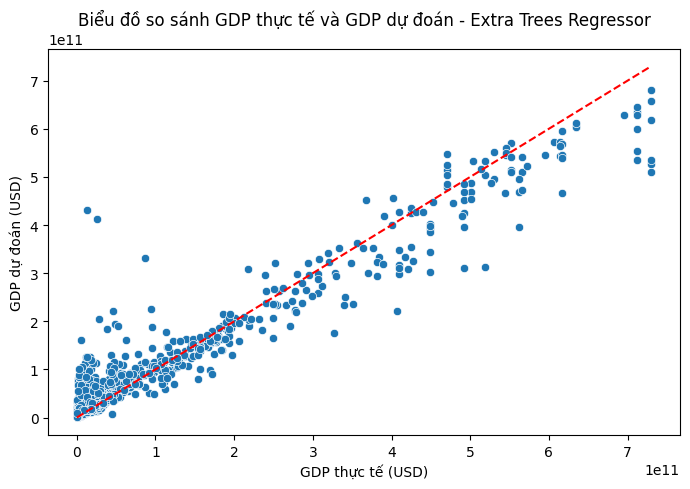

✅ Đã lưu: ExtraTree_actual_vs_predicted.png


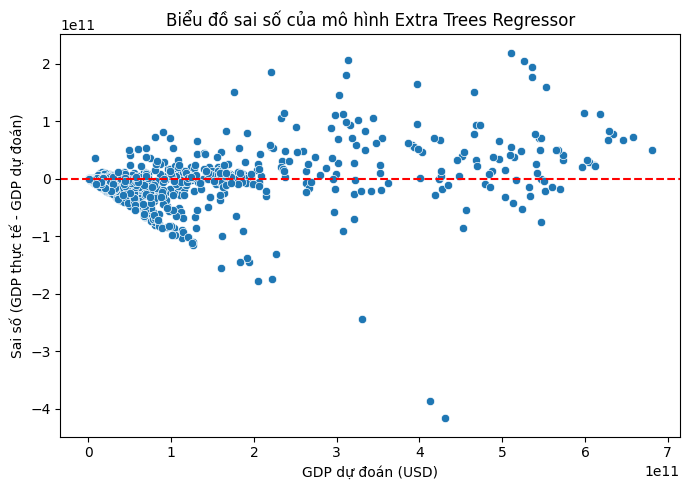

✅ Đã lưu: ExtraTree_residuals.png


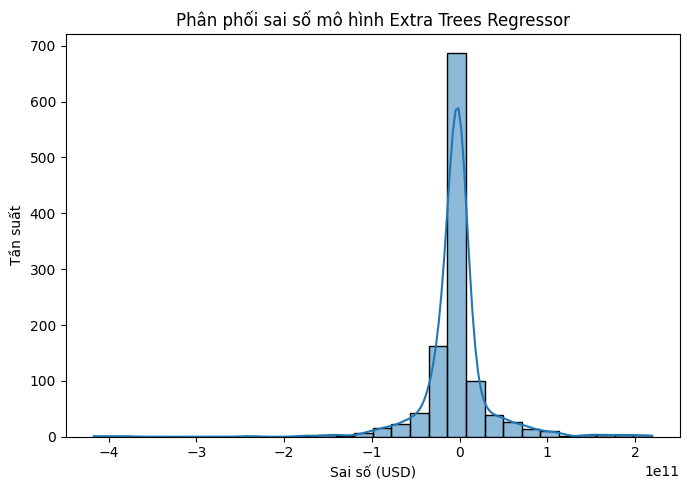

✅ Đã lưu: ExtraTree_error_distribution.png


['..\\output\\model\\extra_trees_model.joblib']

In [88]:
tr = ExtraTreesRegressor(n_estimators=100, random_state=42)
tr.fit(X_train, y_train)
y_pred_tr = tr.predict(X_test)
results_tr = evaluate_model("Extra Trees Regressor", tr, y_test, y_pred_tr)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_tr)
plt.xlabel("GDP thực tế (USD)")
plt.ylabel("GDP dự đoán (USD)")
plt.title("Biểu đồ so sánh GDP thực tế và GDP dự đoán - Extra Trees Regressor")
# Vẽ thêm đường chéo để thấy độ khớp
min_val = min(min(y_test), min(y_pred_tr))
max_val = max(max(y_test), max(y_pred_tr))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "ExtraTree_actual_vs_predicted.png"))
plt.show()
plt.close()
print("✅ Đã lưu: ExtraTree_actual_vs_predicted.png")

# === 2️⃣ Biểu đồ sai số (Residual Plot) ===
residuals = y_test - y_pred_tr
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_tr, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("GDP dự đoán (USD)")
plt.ylabel("Sai số (GDP thực tế - GDP dự đoán)")
plt.title("Biểu đồ sai số của mô hình Extra Trees Regressor")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "ExtraTree_residuals.png"))
plt.show()
plt.close()
print("✅ Đã lưu: ExtraTree_residuals.png")

# === 3️⃣ Biểu đồ phân phối sai số (Histogram) ===
plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Phân phối sai số mô hình Extra Trees Regressor")
plt.xlabel("Sai số (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "ExtraTree_error_distribution.png"))
plt.show()
plt.close()
print("✅ Đã lưu: ExtraTree_error_distribution.png")
plt.show()

model_path = r"..\output\model\extra_trees_model.joblib"
joblib.dump(tr, model_path)


📊 Gradient Boosting Regressor results:
MAE: 55285463107.519 | RMSE: 89292097263.265 | R2: 0.666


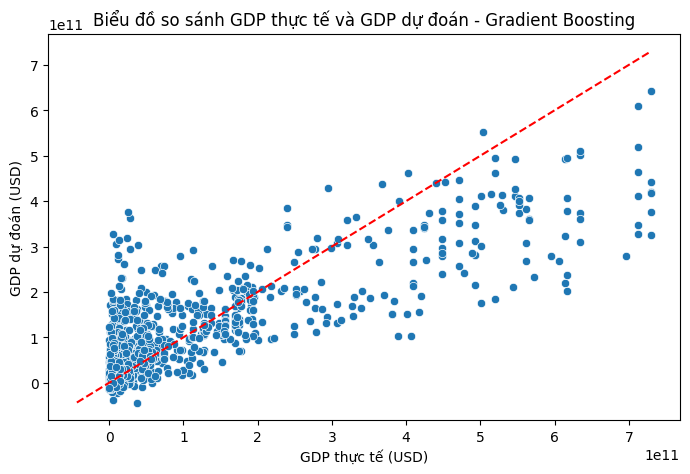

 Đã lưu: GradientBoosting_actual_vs_predicted.png


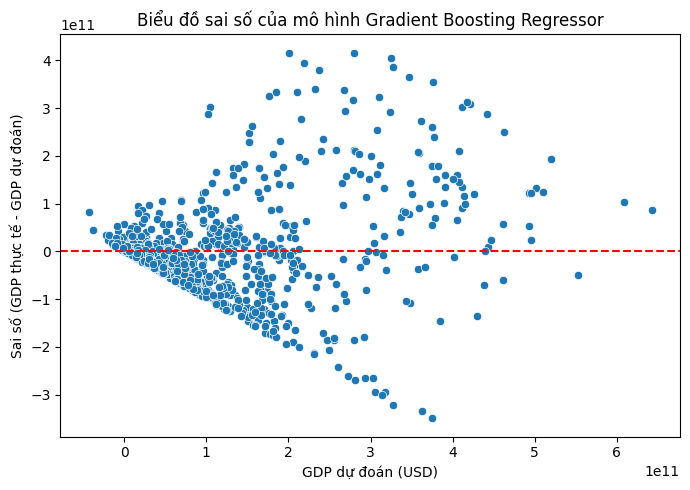

✅ Đã lưu: GradientBoosting_residuals.png


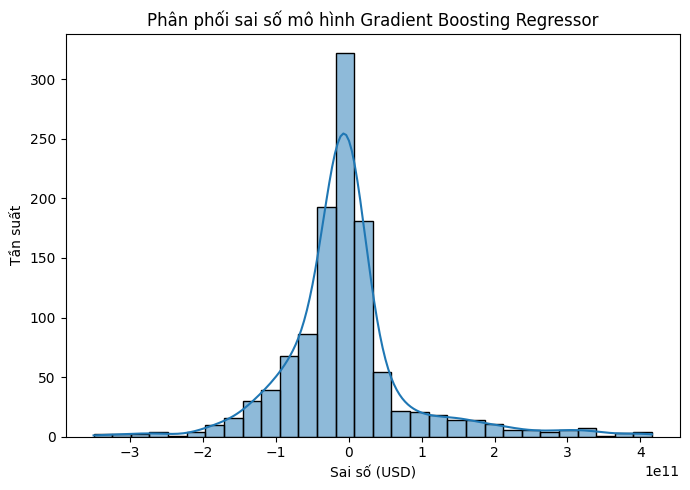

✅ Đã lưu: GraidentBoosting_error_distribution.png


['..\\output\\model\\gradient_boosting_model.joblib']

In [89]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
results_gb = evaluate_model("Gradient Boosting Regressor", gb, y_test, y_pred_gb)
model_path = r"..\output\model\gradient_boosting_model.joblib"
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_gb)
plt.xlabel("GDP thực tế (USD)")
plt.ylabel("GDP dự đoán (USD)")
plt.title("Biểu đồ so sánh GDP thực tế và GDP dự đoán - Gradient Boosting")
min_val = min(min(y_test), min(y_pred_gb))
max_val = max(max(y_test), max(y_pred_gb))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "GradientBoosting_actual_vs_predicted.png"))
plt.show()
plt.close()
print(" Đã lưu: GradientBoosting_actual_vs_predicted.png")


residuals = y_test - y_pred_gb
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_gb, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("GDP dự đoán (USD)")
plt.ylabel("Sai số (GDP thực tế - GDP dự đoán)")
plt.title("Biểu đồ sai số của mô hình Gradient Boosting Regressor")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "GradientBoosting_residuals.png"))
plt.show()
plt.close()
print("✅ Đã lưu: GradientBoosting_residuals.png")

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Phân phối sai số mô hình Gradient Boosting Regressor")
plt.xlabel("Sai số (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "GradientBoosting_error_distribution.png"))
plt.show()
plt.close()
print("✅ Đã lưu: GraidentBoosting_error_distribution.png")
joblib.dump(gb, model_path)


📊 Linear Regression results:
MAE: 95112553018.273 | RMSE: 134103802892.313 | R2: 0.248


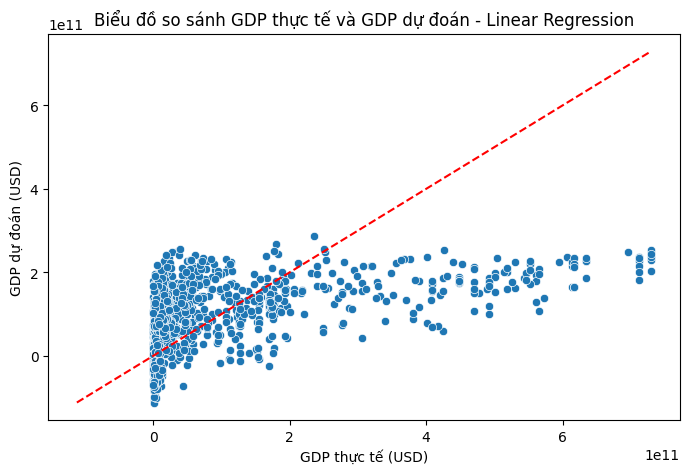

 Đã lưu: LinearRegression_actual_vs_predicted.png


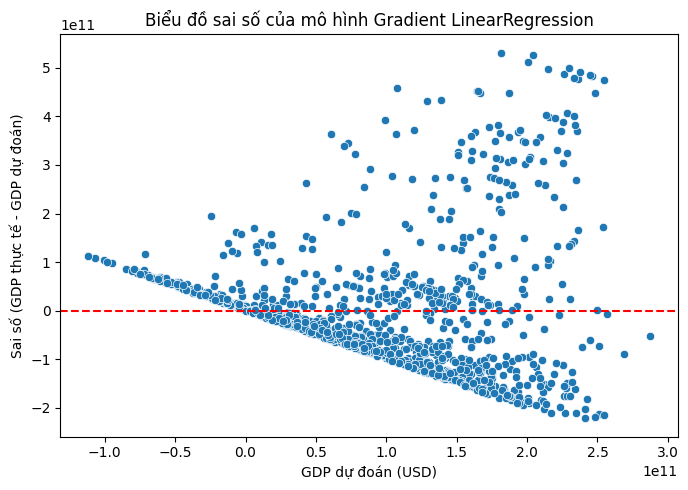

✅ Đã lưu: LinearRegression_residuals.png


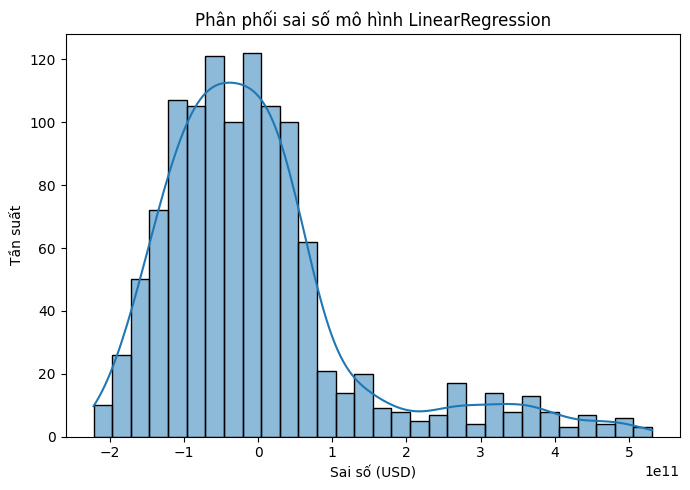

['..\\output\\model\\linear_regression_model.joblib']

In [90]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results_lr = evaluate_model("Linear Regression", lr, y_test, y_pred_lr)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_lr)
plt.xlabel("GDP thực tế (USD)")
plt.ylabel("GDP dự đoán (USD)")
plt.title("Biểu đồ so sánh GDP thực tế và GDP dự đoán - Linear Regression")
min_val = min(min(y_test), min(y_pred_lr))
max_val = max(max(y_test), max(y_pred_lr))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "LinearRegression_actual_vs_predicted.png"))
plt.show()
plt.close()
print(" Đã lưu: LinearRegression_actual_vs_predicted.png")


residuals = y_test - y_pred_lr
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_lr, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("GDP dự đoán (USD)")
plt.ylabel("Sai số (GDP thực tế - GDP dự đoán)")
plt.title("Biểu đồ sai số của mô hình Gradient LinearRegression")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "LinearRegression_residuals.png"))
plt.show()
plt.close()
print("✅ Đã lưu: LinearRegression_residuals.png")

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Phân phối sai số mô hình LinearRegression")
plt.xlabel("Sai số (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "LinearRegression_error_distribution.png"))
plt.show()
plt.close()

model_path = r"..\output\model\linear_regression_model.joblib"
joblib.dump(lr, model_path)


📊 Random Forest results:
MAE: 24254703785.492 | RMSE: 48532920715.749 | R2: 0.901


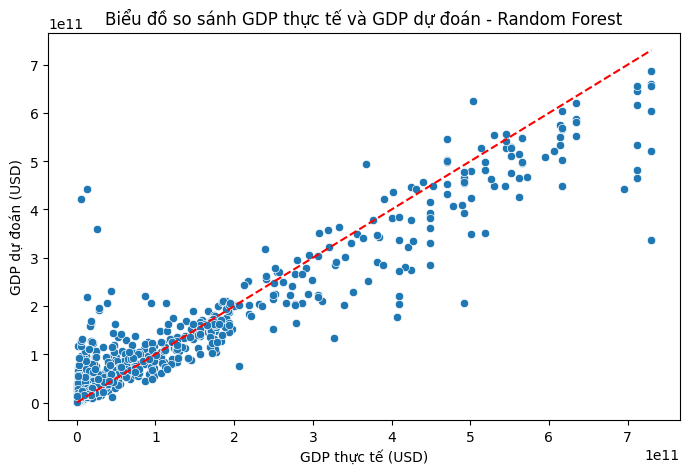

 Đã lưu: RandomForest_actual_vs_predicted.png


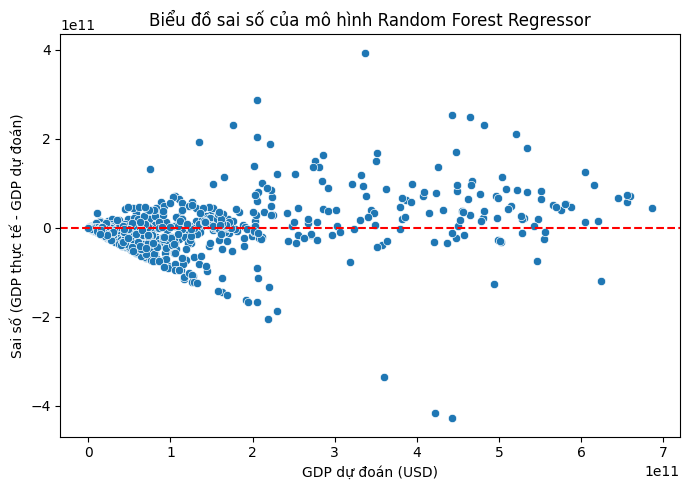

✅ Đã lưu: RandomForest_residuals.png


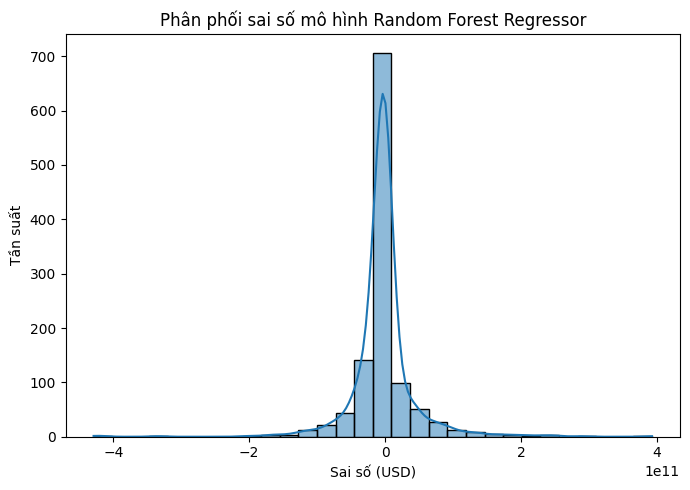

['..\\output\\model\\random_forest_model.joblib']

In [46]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results_rf = evaluate_model("Random Forest", rf, y_test, y_pred_rf)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.xlabel("GDP thực tế (USD)")
plt.ylabel("GDP dự đoán (USD)")
plt.title("Biểu đồ so sánh GDP thực tế và GDP dự đoán - Random Forest")
min_val = min(min(y_test), min(y_pred_rf))
max_val = max(max(y_test), max(y))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "RandomForest_actual_vs_predicted.png"))
plt.show()
plt.close()
print(" Đã lưu: RandomForest_actual_vs_predicted.png")


residuals = y_test - y_pred_rf
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("GDP dự đoán (USD)")
plt.ylabel("Sai số (GDP thực tế - GDP dự đoán)")
plt.title("Biểu đồ sai số của mô hình Random Forest Regressor")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "RandomForest_residuals.png"))
plt.show()
plt.close()
print("✅ Đã lưu: RandomForest_residuals.png")

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Phân phối sai số mô hình Random Forest Regressor")
plt.xlabel("Sai số (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "RandomForest_error_distribution.png"))
plt.show()
plt.close()
model_path = r"..\output\model\random_forest_model.joblib"
joblib.dump(rf, model_path)


📊 Support Vector Regression results:
MAE: 85361202794.451 | RMSE: 170480642090.344 | R2: -0.216


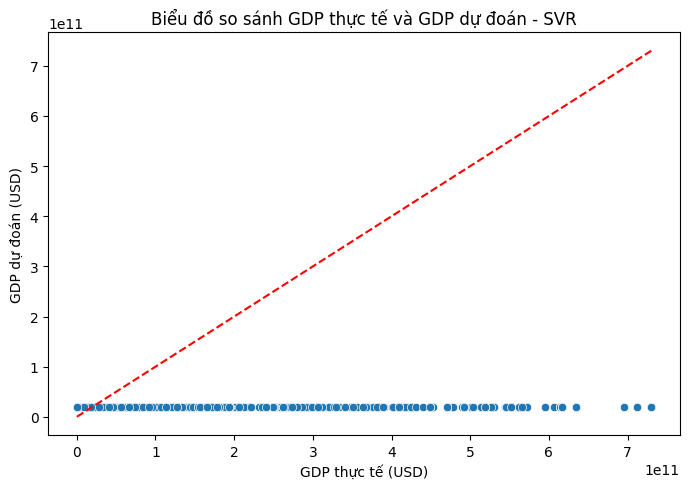

✅ Đã lưu: svr_actual_vs_predicted.png


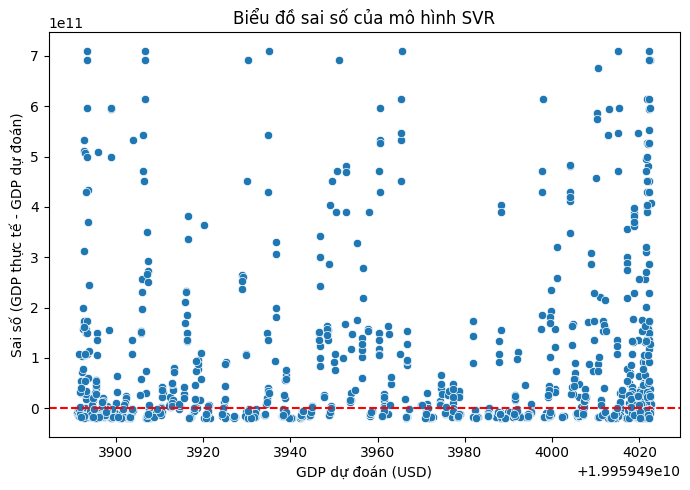

✅ Đã lưu: svr_residuals.png


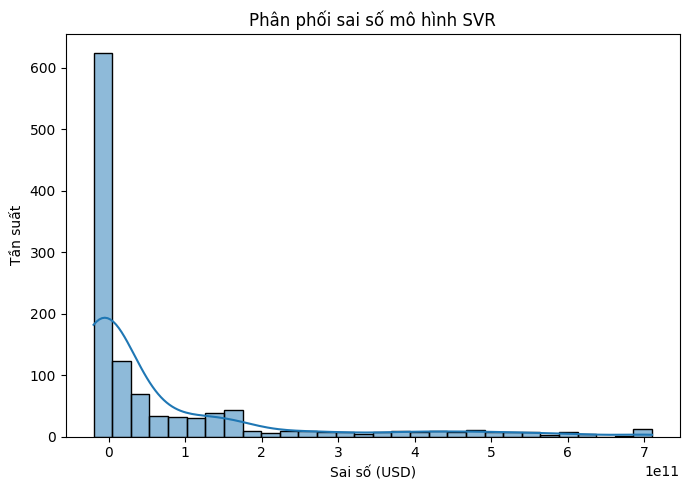

✅ Đã lưu: svr_error_distribution.png


['..\\output\\model\\svr_model.joblib']

In [47]:
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
results_svr = evaluate_model("Support Vector Regression", svr, y_test, y_pred_svr)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_test, y=y_pred_svr)
plt.xlabel("GDP thực tế (USD)")
plt.ylabel("GDP dự đoán (USD)")
plt.title("Biểu đồ so sánh GDP thực tế và GDP dự đoán - SVR")

min_val = min(min(y_test), min(y_pred_svr))
max_val = max(max(y_test), max(y_pred_svr))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.tight_layout()
plt.savefig(os.path.join(output_path, "svr_actual_vs_predicted.png"))
plt.show()
plt.close()
print("✅ Đã lưu: svr_actual_vs_predicted.png")


residuals = y_test - y_pred_svr
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_svr, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("GDP dự đoán (USD)")
plt.ylabel("Sai số (GDP thực tế - GDP dự đoán)")
plt.title("Biểu đồ sai số của mô hình SVR")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "svr_residuals.png"))
plt.show()
plt.close()
print("✅ Đã lưu: svr_residuals.png")

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Phân phối sai số mô hình SVR")
plt.xlabel("Sai số (USD)")
plt.ylabel("Tần suất")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "svr_error_distribution.png"))
plt.show()
plt.close()
print("✅ Đã lưu: svr_error_distribution.png")
model_path = r"..\output\model\svr_model.joblib"
joblib.dump(svr, model_path)

In [48]:
results = pd.DataFrame([results_lr, results_rf, results_svr,results_tr,results_gb])
print("\n📈 So sánh mô hình:\n", results)



📈 So sánh mô hình:
                          Model            MAE            RMSE    R2
0            Linear Regression 95112553018.27 134103802892.31  0.25
1                Random Forest 24254703785.49  48532920715.75  0.90
2    Support Vector Regression 85361202794.45 170480642090.34 -0.22
3        Extra Trees Regressor 20073909209.32  40058235572.40  0.93
4  Gradient Boosting Regressor 55285463107.52  89292097263.26  0.67


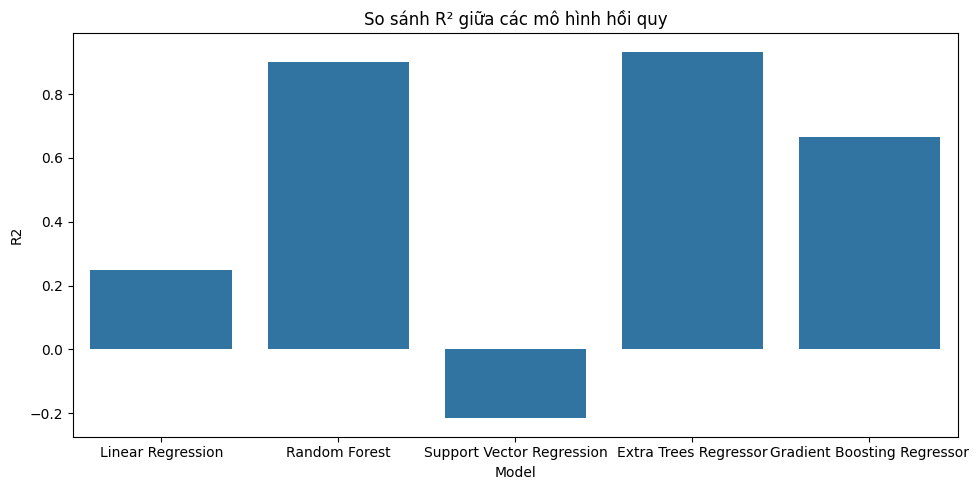

In [92]:
plt.figure(figsize=(10,5))
sns.barplot(data=results, x="Model", y="R2")
plt.title("So sánh R² giữa các mô hình hồi quy")
plt.tight_layout()
plt.savefig(os.path.join(output_path, "model_comparison.png"))
plt.show()
plt.close()

In [93]:


model = joblib.load(r"..\output\model\extra_trees_model.joblib")

country = input("Nhập tên quốc gia: ")
year = int(input("Năm: "))
agri = float(input("Lao động nông nghiệp (%): "))
ind = float(input("Lao động công nghiệp (%): "))
serv = float(input("Lao động dịch vụ (%): "))
unemp = float(input("Tỷ lệ thất nghiệp (%): "))

country_code = le.transform([country])[0]

# Tạo DataFrame
new_data = pd.DataFrame({
    'Country_Code': [country_code],
    'Year': [year],
    'Labor_Agriculture': [agri],
    'Labor_Industry': [ind],
    'Labor_Services': [serv],
    'Unemployment_Rate': [unemp]
})

# Chuẩn hóa các cột liên tục
cols_to_scale = ['Year', 'Labor_Agriculture', 'Labor_Industry', 'Labor_Services', 'Unemployment_Rate']
new_scaled = new_data.copy()
new_scaled[cols_to_scale] = scaler.transform(new_data[cols_to_scale])

# Dự đoán GDP
pred = model.predict(new_scaled)[0]
print(f"\n🌍 Quốc gia: {country}")
print(f"📅 Năm: {year}")
print(f"📈 Dự đoán GDP: {pred:,.2f} USD")



🌍 Quốc gia: Viet Nam
📅 Năm: 2022
📈 Dự đoán GDP: 343,009,024,609.09 USD
